# **Modeling**

# 0.0. Imports

In [15]:
import pandas                                                           as pd
import numpy                                                            as np
import seaborn                                                          as sns
import matplotlib.pyplot                                                as plt
import pickle
import scikitplot                                                       as skplt
import xgboost                                                          as xgb
import lightgbm                                                         as lgb
import optuna

from numerize                       import numerize                     as nm
from optuna                         import samplers                     as os
from scipy                          import stats                        as st
from sklearn                        import ensemble                     as en
from sklearn                        import model_selection              as ms
from sklearn                        import preprocessing                as pp
from sklearn                        import neighbors                    as nh
from sklearn                        import linear_model                 as lm
from sklearn                        import metrics                      as mt


from IPython.core.display           import HTML
from IPython.display                import Image

import warnings
warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [16]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24,12]
    plt.rcParams['font.size'] = 20
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 12
    
    display(HTML ('<style>.container {width: 80% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    palette = ["#856088","#7BA05B", "#7BAFD4", "#FFC40C", "#B53389"]
    colors = sns.color_palette(palette=palette)
    sns.set_palette(colors)
    
jupyter_settings()

In [17]:
def ranking_metrics (data, model, yhat, k=20000):
    # propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clientes by propensity score
    data = data.sort_values('score', ascending=False)

    # reset index - start recall and precision
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    # create precision
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    precision_at_k =  data.loc[k, 'precision_at_k']
    # create recall
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    recall_at_k = data.loc[k, 'recall_at_k']

    return pd.DataFrame ( {'Precision_Top_K': np.round((precision_at_k),4),
                           'Recall_Top_K': np.round((recall_at_k),4),
                           'Model Name': type(model).__name__,
                            }, index = [0] )


def curve(y_val, yhat, axvline=None, axhline=None):
    fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

    # Accumulative Gain
    skplt.metrics.plot_cumulative_gain(y_val, yhat, ax=axs[0])

    if axhline is not None:
        axs[0].axhline(axhline, color='#006D6F', ls='--', lw=2)

    # Lift Curve
    skplt.metrics.plot_lift_curve(y_val, yhat, ax=axs[1])

    if axvline is not None:
        axs[0].axvline(axvline, 0, 1, color='#006D6F', ls='--', lw=2)
        axs[1].axvline(axvline, 0, 1, color='#006D6F', ls='--', lw=2)


In [18]:
def cross_validation(model, x_train, y_train, kmetrics, kf=5):
    kfold = ms.StratifiedKFold(n_splits=kf, shuffle=True, random_state=42)
    fold_results = []  
    
    for i, (train_cv, val_cv) in enumerate(kfold.split(x_train, y_train), start=1):
        x_train_fold, x_val_fold = x_train.iloc[train_cv], x_train.iloc[val_cv]
        y_train_fold, y_val_fold = y_train.iloc[train_cv], y_train.iloc[val_cv]

        # Fit the model
        model.fit(x_train_fold, y_train_fold)

        # Model prediction
        yhat = model.predict_proba(x_val_fold)

        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()

        # Propensity score
        data['score'] = yhat[:, 1].tolist()

        # Sort clients by propensity
        data = data.sort_values('score', ascending=False)

        # Reset index and start recall and precision calculation
        data = data.reset_index(drop=True)

        # Create ranking order
        data['ranking'] = data.index + 1

        # Create precision
        data['precision_at_k'] = data['response'].cumsum() / data['ranking']
        data['precision_at_k'] = data.loc[kmetrics, 'precision_at_k']

        # Create recall
        data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
        data['recall_at_k'] = data.loc[kmetrics, 'recall_at_k']

        # Calculate ROC
        roc = mt.roc_auc_score(y_val_fold, yhat[:, 1])

        fold_results.append({
            'Fold': i,
            'Precision_Top_K': np.round(data.loc[kmetrics, 'precision_at_k'],2),
            'Recall_Top_K': np.round(data.loc[kmetrics, 'recall_at_k'],2),
            'ROC': np.round(roc,2)
        })

    # Convert the list of fold results into a DataFrame
    result_df = pd.DataFrame(fold_results)
    
    # Calculate the mean metrics across all folds
    mean_metrics = result_df[['Precision_Top_K', 'Recall_Top_K', 'ROC']].mean()
    mean_metrics['Fold'] = 'Final'
    result_df = result_df.append(mean_metrics, ignore_index=True)
    result_df['Model Name'] = type(model).__name__

    return result_df

## 0.2. Loading Data

In [19]:
# train
train= pd.read_csv('../data/interim/train_enconding.csv')

#validation
validation = pd.read_csv('../data/interim/validation_enconding.csv')

In [20]:
validation.head()

id    gender       age  driving_license  region_code  previously_insured  vehicle_age  vehicle_damage  annual_premium  policy_sales_channel  days_associated  response
0  179402  0.105247  0.630769                1     0.280680                   0     0.526751               1        0.059658              0.194183         0.231834         0
1  110750  0.138884  0.584615                1     0.088820                   1     0.526751               0        0.316210              0.194183         0.747405         0
2  192903  0.138884  0.476923                1     0.280680                   0     0.526751               1       -0.028555              0.002034         0.709343         0
3  188632  0.138884  0.415385                1     0.004434                   0     0.526751               1        0.085047              0.007452         0.595156         0
4    7520  0.105247  0.015385                1     0.027918                   0     0.431490               1        0.555514              0.352733         0.903114         0

In [21]:
train.shape, validation.shape

((243909, 12), (76222, 12))

# 7.0. Machine Learning Modelling

In [22]:
cols_selected = ['age', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel']

x_train = train[cols_selected]
y_train = train['response'].copy()

x_val = validation[cols_selected]
y_val = validation['response'].copy()

In [23]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((243909, 7), (243909,), (76222, 7), (76222,))

### 7.1. KNN Classifier

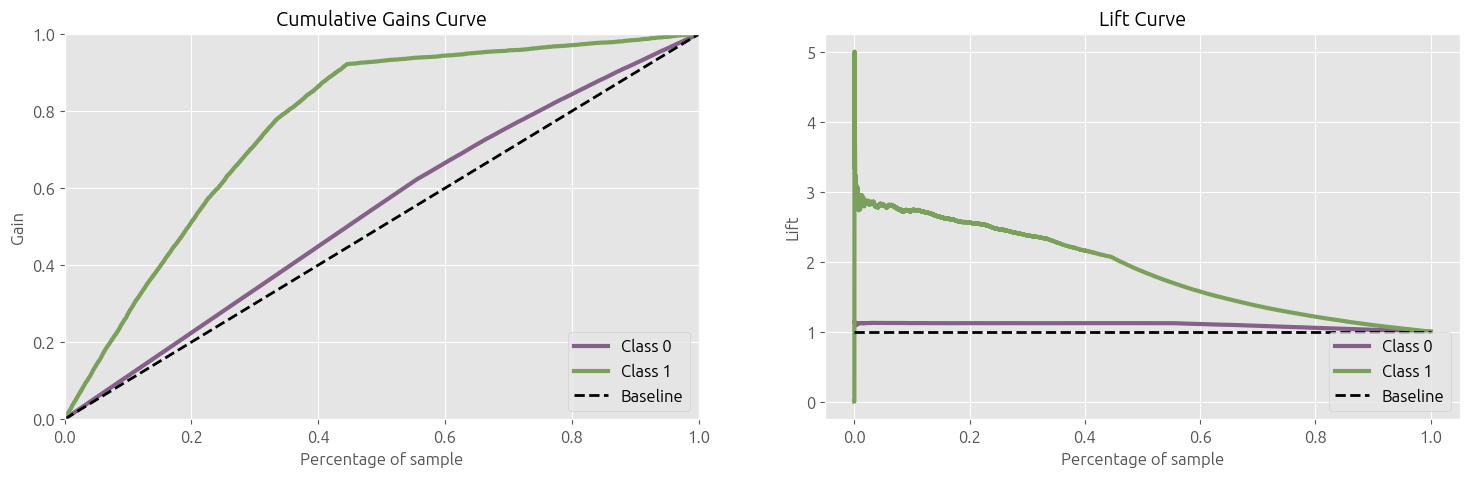

In [10]:
# model definition
knn_clf = nh.KNeighborsClassifier(n_neighbors=10)

# model training
knn_clf.fit(x_train, y_train)

# model prediction
yhat_knn = knn_clf.predict_proba(x_val)

# plot
curve(y_val, yhat_knn)

#### 7.1.1. KNN Classifier - Cross Validation

In [12]:
cross_validation (knn_clf, x_train, y_train, 20000, kf=5)

Fold  Precision_Top_K  Recall_Top_K    ROC            Model Name
0      1             0.26         0.870  0.800  KNeighborsClassifier
1      2             0.26         0.880  0.800  KNeighborsClassifier
2      3             0.26         0.880  0.810  KNeighborsClassifier
3      4             0.26         0.880  0.810  KNeighborsClassifier
4      5             0.26         0.870  0.800  KNeighborsClassifier
5  Final             0.26         0.876  0.804  KNeighborsClassifier

In [13]:
knn_result_cv = cross_validation (knn_clf, x_train, y_train, 20000, kf=5)
knn_result_cv = knn_result_cv.loc[knn_result_cv['Fold'] == 'Final']

### 7.2. Linear Regression

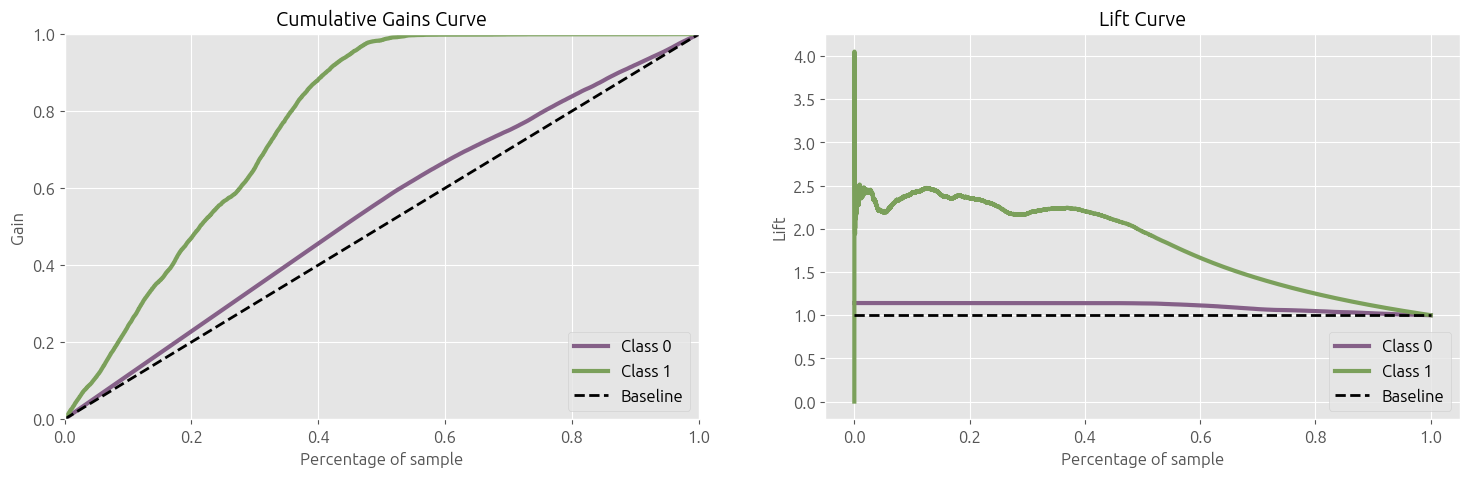

In [11]:
# model definition
lr = lm.LogisticRegression(random_state=0)

# model training
lr.fit(x_train, y_train)

# model prediction
yhat_lr = lr.predict_proba(x_val)

# plot
curve(y_val, yhat_lr)

#### 7.2.1. Linear Regression - Cross Validation

In [15]:
cross_validation (lr, x_train, y_train, 20000, kf=5)

Fold  Precision_Top_K  Recall_Top_K    ROC          Model Name
0      1             0.27          0.90  0.810  LogisticRegression
1      2             0.27          0.91  0.820  LogisticRegression
2      3             0.27          0.90  0.810  LogisticRegression
3      4             0.27          0.90  0.810  LogisticRegression
4      5             0.27          0.89  0.810  LogisticRegression
5  Final             0.27          0.90  0.812  LogisticRegression

In [16]:
lr_result_cv = cross_validation (lr, x_train, y_train, 20000, kf=5)
lr_result_cv = lr_result_cv.loc[lr_result_cv['Fold'] == 'Final']

### 7.3. XGB Classifier

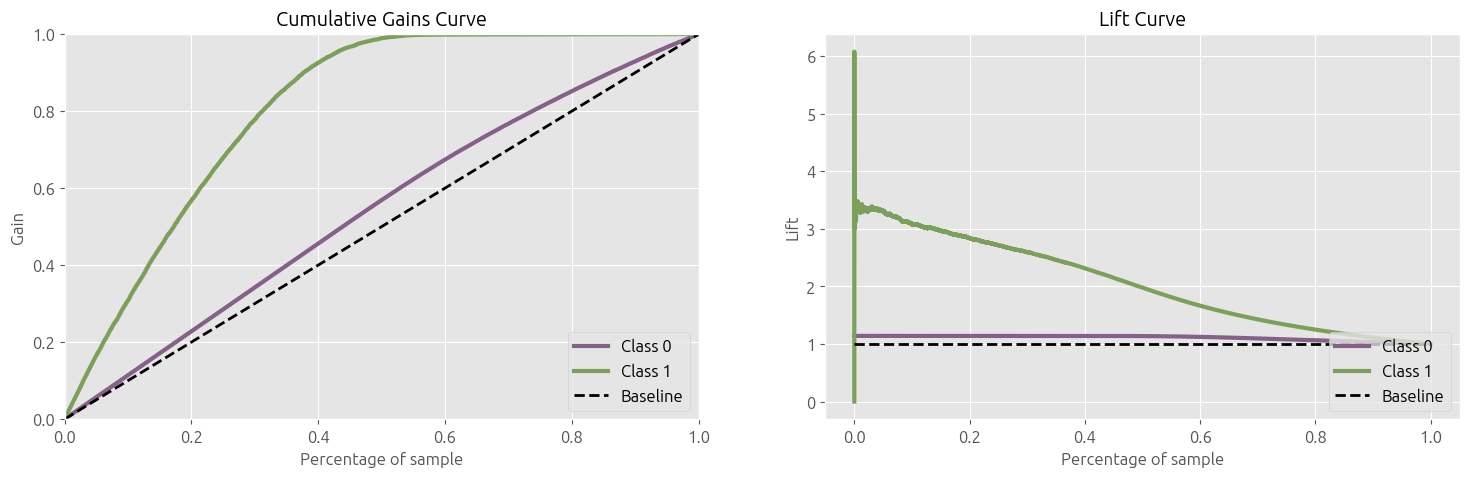

In [12]:
# model definition
xgb_clf= xgb.XGBClassifier()
# model training
xgb_clf.fit(x_train, y_train)

# model prediction
yhat_xgb = xgb_clf.predict_proba(x_val)

# plot
curve(y_val, yhat_xgb)

#### 7.3.1. XGB Classifier - Cross Validation

In [18]:
cross_validation (xgb_clf, x_train, y_train, 20000, kf=5)

Fold  Precision_Top_K  Recall_Top_K    ROC     Model Name
0      1             0.28          0.93  0.850  XGBClassifier
1      2             0.28          0.93  0.850  XGBClassifier
2      3             0.28          0.93  0.860  XGBClassifier
3      4             0.28          0.93  0.860  XGBClassifier
4      5             0.28          0.93  0.850  XGBClassifier
5  Final             0.28          0.93  0.854  XGBClassifier

In [19]:
xgb_result_cv = cross_validation (xgb_clf, x_train, y_train, 20000, kf=5)
xgb_result_cv = xgb_result_cv.loc[xgb_result_cv['Fold'] == 'Final']

### 7.4. Extra Trees Classifier

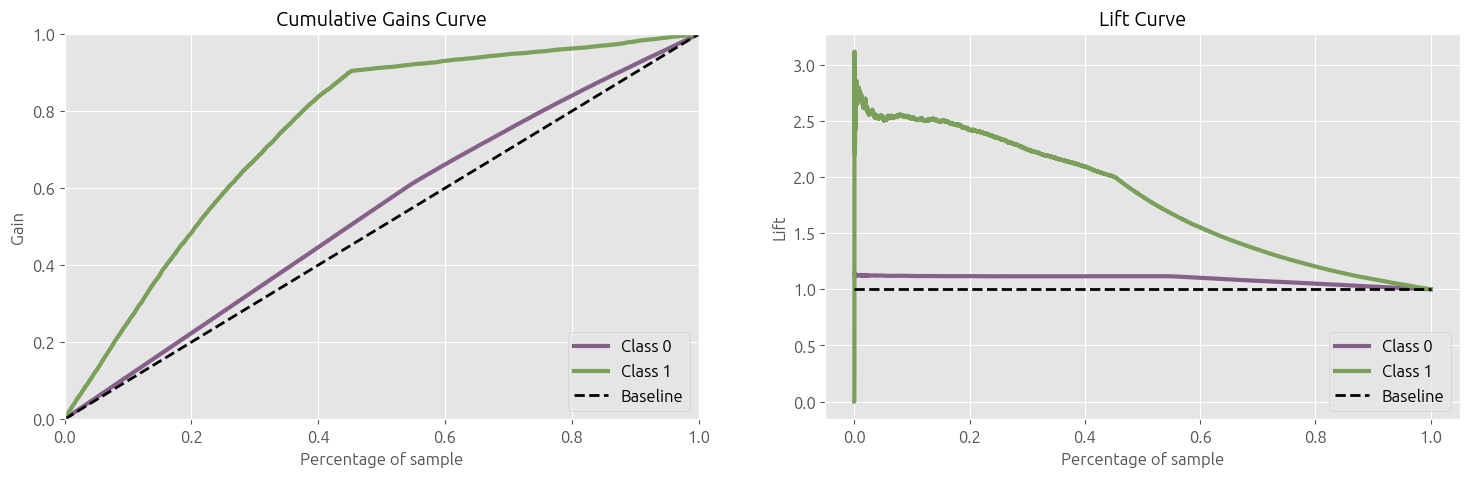

In [13]:
# model definition
et_clf = en.ExtraTreesClassifier();

# model training
et_clf.fit(x_train, y_train);

# model prediction
yhat_et = et_clf.predict_proba(x_val);

# plot
curve(y_val, yhat_et)

#### 7.4.1. Extra Trees Classifier - Cross Validation

In [22]:
cross_validation (et_clf, x_train, y_train, 20000, kf=5)

Fold  Precision_Top_K  Recall_Top_K    ROC            Model Name
0      1             0.25         0.840  0.760  ExtraTreesClassifier
1      2             0.25         0.840  0.770  ExtraTreesClassifier
2      3             0.25         0.840  0.770  ExtraTreesClassifier
3      4             0.25         0.840  0.770  ExtraTreesClassifier
4      5             0.25         0.830  0.760  ExtraTreesClassifier
5  Final             0.25         0.838  0.766  ExtraTreesClassifier

In [23]:
et_result_cv = cross_validation (et_clf, x_train, y_train, 20000, kf=5)
et_result_cv = et_result_cv.loc[et_result_cv['Fold'] == 'Final']

### 7.5. LightGBM Classifier

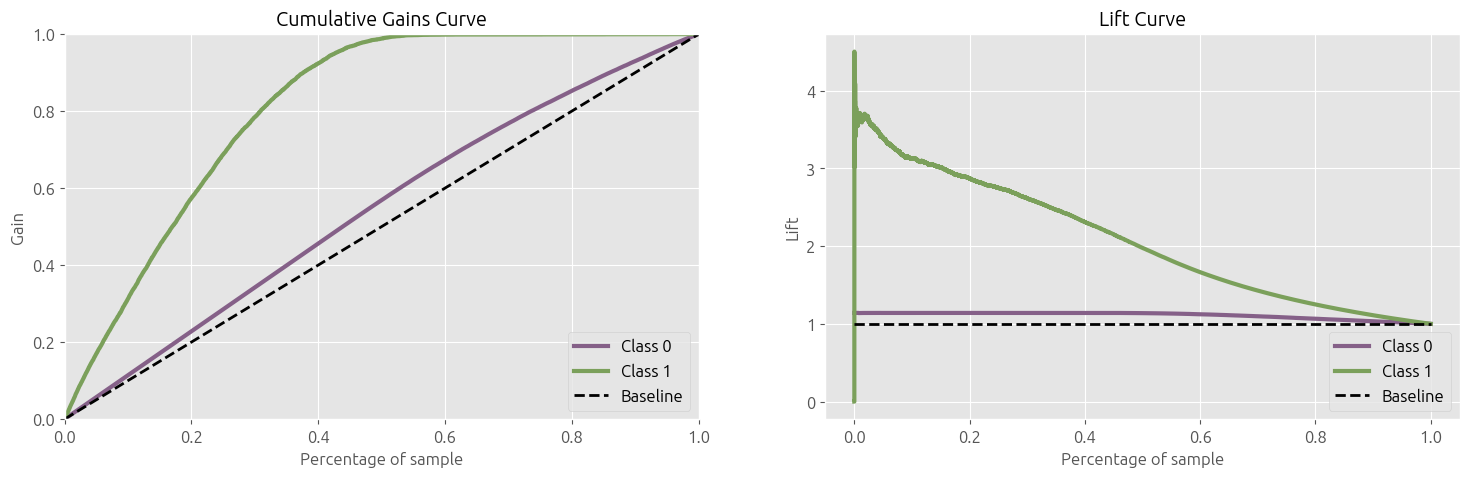

In [14]:
# model definition
lgb_clf = lgb.LGBMClassifier()
lgb_clf.set_params(verbose=-1) 

# model training
lgb_clf.fit(x_train, y_train);

# model prediction
yhat_lgb = lgb_clf.predict_proba(x_val);

# plot
curve(y_val, yhat_lgb)

#### 7.5.1. LightGBM Classifier - Cross Validation

In [26]:
cross_validation (lgb_clf, x_train, y_train, 20000, kf=5)

Fold  Precision_Top_K  Recall_Top_K    ROC      Model Name
0      1             0.28         0.930  0.850  LGBMClassifier
1      2             0.28         0.930  0.860  LGBMClassifier
2      3             0.28         0.940  0.860  LGBMClassifier
3      4             0.28         0.930  0.860  LGBMClassifier
4      5             0.28         0.930  0.850  LGBMClassifier
5  Final             0.28         0.932  0.856  LGBMClassifier

In [27]:
lgb_result_cv = cross_validation (lgb_clf, x_train, y_train, 20000, kf=5)
lgb_result_cv = lgb_result_cv.loc[lgb_result_cv['Fold'] == 'Final']

## 7.6. Compare Model's Performance

In [26]:
# coded dataset
df_compared = x_val.copy()
df_compared['response'] = y_val.copy()

###  7.6.1. Single Performance

In [32]:
# performance

knn_result = ranking_metrics (df_compared, knn_clf, yhat_knn, k=20000 )
lr_result = ranking_metrics (df_compared, lr, yhat_lr, k=20000 )
xgb_result = ranking_metrics (df_compared, xgb_clf, yhat_xgb,k=20000 )
et_result = ranking_metrics(df_compared,  et_clf, yhat_et, k=20000 )
lgb_result = ranking_metrics (df_compared,  lgb_clf,yhat_lgb, k=20000 )

modelling_result = pd.concat ([ knn_result, lr_result, xgb_result, et_result, lgb_result ])
modelling_result.sort_values('Precision_Top_K', ascending=False)

Precision_Top_K  Recall_Top_K            Model Name
0           0.3361        0.7147        LGBMClassifier
0           0.3311        0.7039         XGBClassifier
0           0.3013        0.6406  KNeighborsClassifier
0           0.2867        0.6095  ExtraTreesClassifier
0           0.2716        0.5774    LogisticRegression

###  7.6.2. Real Performance - Cross Validation

In [33]:
# performance
modelling_result = pd.concat ([knn_result_cv, lr_result_cv, xgb_result_cv, et_result_cv, lgb_result_cv ], ignore_index=True)
modelling_result.sort_values('Precision_Top_K', ascending=False)

Fold  Precision_Top_K  Recall_Top_K    ROC            Model Name
2  Final             0.28         0.930  0.854         XGBClassifier
4  Final             0.28         0.932  0.856        LGBMClassifier
1  Final             0.27         0.900  0.812    LogisticRegression
0  Final             0.26         0.876  0.804  KNeighborsClassifier
3  Final             0.25         0.838  0.768  ExtraTreesClassifier

# 8.0. Hyperparameter Fine Tuning


## 8.1. GridSearchCV

In [42]:
lgb_classifier = lgb.LGBMClassifier(random_state=42)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 5, 6],
    'num_leaves': [8, 16, 20],
    'subsample': [0.3, 0.5, 0.7],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_samples': [4, 20, 36],
    'scale_pos_weight': [5, 6, 7]
}

# Initialize GridSearchCV with ROC AUC as the scoring metric
grid_search = ms.GridSearchCV(estimator=lgb_classifier, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Train a LightGBM model with the best hyperparameters
best_lgb_model = lgb.LGBMClassifier(**best_params, random_state=42)
best_lgb_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = best_lgb_model.predict(x_val)
y_prob = best_lgb_model.predict_proba(x_val)[:, 1]

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remov

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.5s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `fo

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.5s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004302 seconds.
You can set `for

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 19512

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from sc

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002332 se

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tot

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 19512

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 19512

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, be

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1951

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Num

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Aut

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1951

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Num

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Num

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=20, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Num

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=20, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of neg

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of n

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.7; 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1951

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, b

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of n

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of n

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading,

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadin

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadin

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadin

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 19512

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 19512

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Num

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of neg

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading,

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of n

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of n

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1951

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1951

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of n

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1951

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of neg

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading,

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of n

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of n

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadin

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadin

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.5s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading,

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading,

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 19512

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from sc

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 19512

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, be

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree

[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Aut

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1951

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1951

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=20, 

[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of neg

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of neg

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.3; 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.5; 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of n

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=8, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.5s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=4, num_leaves=20, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=6, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=16, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of n

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of n

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=20, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.3; total time=   0.5s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `forc

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.5s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=6, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=8, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, 

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=5, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.5s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=6, subsample=0.7; total time=   0.5s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195128, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122094 -> initscore=-1.972746
[LightGBM] [Info] Start training from score -1.972746
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=16, scale_pos_weight=7, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=5, subsample=0.5; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.5s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.3; total time=   0.4s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=6, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.3; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 195127, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972740
[LightGBM] [Info] Start training from score -1.972740
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=6, min_child_samples=36, num_leaves=20, scale_pos_weight=7, subsample=0.7; total time=   0.3s
[LightGBM] [Info] Number of positive: 23824, number of negative: 171303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading

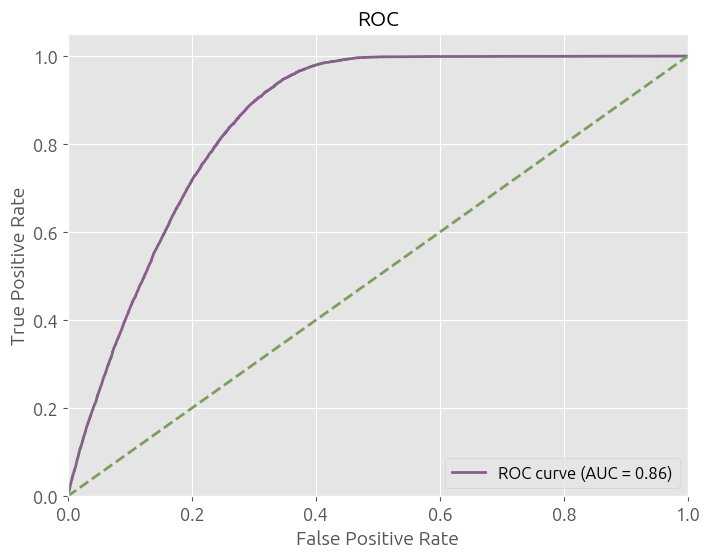

In [43]:
# Calculate precision
precision = mt.precision_score(y_val, y_pred)

# Calculate ROC AUC score
roc_auc = mt.roc_auc_score(y_val, y_prob)

# Plot ROC curve
fpr, tpr, _ = mt.roc_curve(y_val, y_prob)
roc_auc_curve = mt.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color= '#856088', lw=2, label=f'ROC curve (AUC = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='#7BA05B', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()


In [44]:
print(f'Precision: {precision:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print(f'Best Hyperparameters: {best_params}')

Precision: 0.30
ROC AUC: 0.86
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 36, 'num_leaves': 20, 'scale_pos_weight': 5, 'subsample': 0.3}


In [29]:
param_tuned = {'objective': 'binary', 'colsample_bytree': 0.7, 'learning_rate': 0.1, 
               'max_depth': 6, 'min_child_samples': 36, 'num_leaves': 20, 'scale_pos_weight': 5, 'subsample': 0.3}

lgb_model_tuned = lgb.LGBMClassifier(objective= param_tuned['objective'],
                                     learning_rate = param_tuned['learning_rate'],
                                     max_depth = param_tuned['max_depth'],
                                     num_leaves = param_tuned['num_leaves'],
                                     subsample = param_tuned['subsample'],
                                     colsample_bytree = param_tuned['colsample_bytree'],
                                     min_child_samples= param_tuned['min_child_samples'],
                                     scale_pos_weight = param_tuned['scale_pos_weight']).fit(x_train, y_train);


# prediction
yhat_lgb_tuned = lgb_model_tuned.predict_proba(x_val);

[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


In [30]:
# performance
lgb_tuned_result = ranking_metrics(df_compared, lgb_model_tuned, yhat_lgb_tuned, k=20000)
lgb_tuned_result

Precision_Top_K  Recall_Top_K      Model Name
0           0.3349         0.712  LGBMClassifier

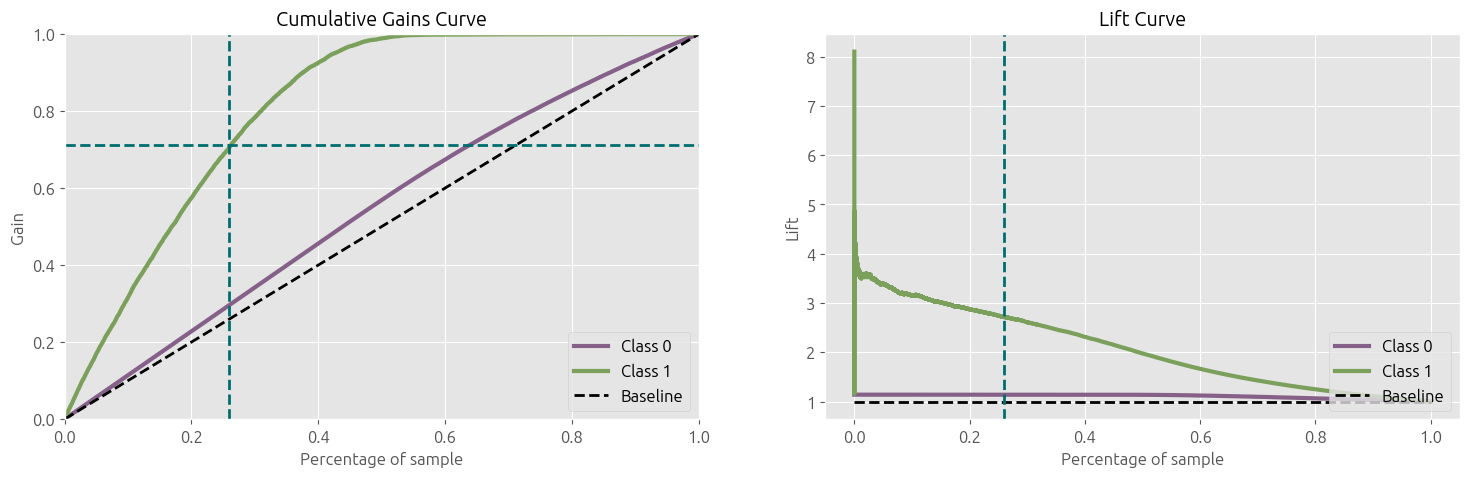

In [31]:
curve(y_val, yhat_lgb_tuned, axhline=0.712,  axvline=0.26)

In [ ]:
# pickle.dump (ltb_model_tuned, open ('../src/models/lgbm.pkl', 'wb') )
# pickle.dump (yhat_ltb_tuned, open ('../src/models/yhat_lgbm.pkl', 'wb') )

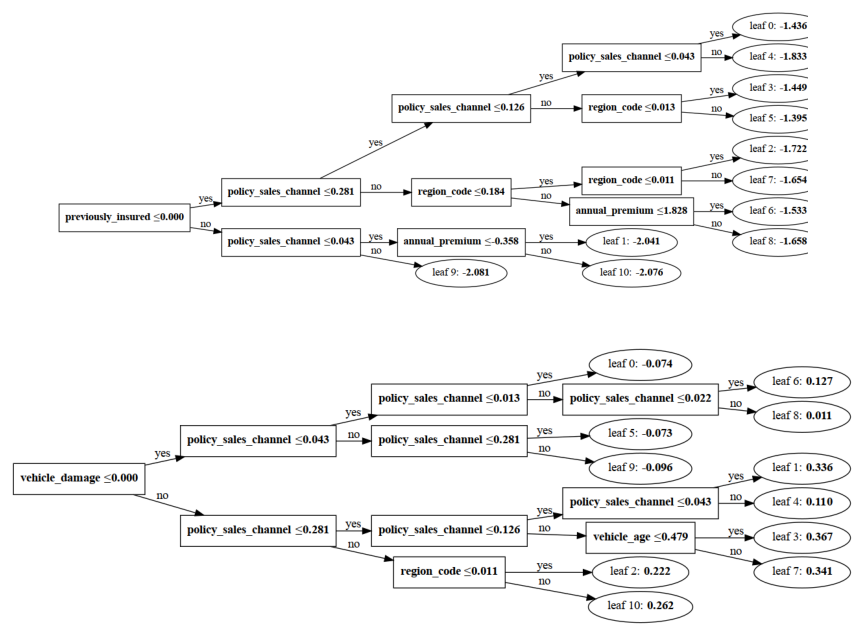

In [138]:
fig, ax = plt.subplots(nrows=2, figsize=(20,8), sharex=True);
lgb.plot_tree(lgb_model_tuned, tree_index=0,dpi=300, ax=ax[0]);
lgb.plot_tree(lgb_model_tuned, tree_index=1,dpi=300, ax=ax[1]);

## 8.2. Optuna

In [34]:
def objective(trial):
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 4, 16),
        'max_depth': trial.suggest_int('max_depth', 2, 4),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 120),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 4.5, 7.5),
        'metric': 'aucpr'
    }
    
    train_data = lgb.Dataset(x_train, label=y_train)  
    valid_data = lgb.Dataset(x_val, label=y_val, reference=train_data)  
    
    callbacks = [lgb.early_stopping(10, first_metric_only=False)]  
    
    gbm = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, valid_data])
    
    y_pred_proba = gbm.predict(x_val)
    
    threshold = 0.5
    y_pred_binary = (y_pred_proba > threshold).astype(int)
    
    roc_auc = mt.roc_auc_score(y_val, y_pred_proba)
    return roc_auc

In [35]:
sampler = os.TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2023-09-05 10:28:42,526] A new study created in memory with name: lightgbm


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:42,933] Trial 0 finished with value: 0.846171208680119 and parameters: {'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.0010005268542378305, 'feature_fraction': 0.3720993153686558, 'bagging_fraction': 0.23208030173540176, 'min_data_in_leaf': 12, 'scale_pos_weight': 5.058780634133012}. Best is trial 0 with value: 0.846171208680119.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:43,269] Trial 1 finished with value: 0.8460744621043202 and parameters: {'num_leaves': 8, 'max_depth': 3, 'learning_rate': 0.011957309429716375, 'feature_fraction': 0.4772750629629653, 'bagging_fraction': 0.7166975503570835, 'min_data_in_leaf': 25, 'scale_pos_weight': 7.1343523091728365}. Best is trial 0 with value: 0.846171208680119.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:43,594] Trial 2 finished with value: 0.8435712518491897 and parameters: {'num_leaves': 4, 'max_depth': 4, 'learning_rate': 0.006832971428089609, 'feature_fraction': 0.6028208456011764, 'bagging_fraction': 0.2263482447357104, 'min_data_in_leaf': 24, 'scale_pos_weight': 6.90223370602661}. Best is trial 0 with value: 0.846171208680119.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:43,926] Trial 3 finished with value: 0.8394435429961786 and parameters: {'num_leaves': 16, 'max_depth': 2, 'learning_rate': 0.02424628643038783, 'feature_fraction': 0.8887502370664345, 'bagging_fraction': 0.9051459971534626, 'min_data_in_leaf': 11, 'scale_pos_weight': 4.617164349698647}. Best is trial 0 with value: 0.846171208680119.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:44,283] Trial 4 finished with value: 0.8450685279362061 and parameters: {'num_leaves': 6, 'max_depth': 4, 'learning_rate': 0.0015728730372487206, 'feature_fraction': 0.478996862504547, 'bagging_fraction': 0.9621005771354517, 'min_data_in_leaf': 64, 'scale_pos_weight': 6.57563134185142}. Best is trial 0 with value: 0.846171208680119.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2023-09-05 10:28:44,601] Trial 5 finished with value: 0.8388071074653625 and parameters: {'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.0466929533152365, 'feature_fraction': 0.11645944960977263, 'bagging_fraction': 0.7751298834504707, 'min_data_in_leaf': 119, 'scale_pos_weight': 6.744496963139518}. Best is trial 0 with value: 0.846171208680119.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:44,944] Trial 6 finished with value: 0.847242006234226 and parameters: {'num_leaves': 7, 'max_depth': 4, 'learning_rate': 0.0016086146261367422, 'feature_fraction': 0.5031041735583147, 'bagging_fraction': 0.917735952783786, 'min_data_in_leaf': 36, 'scale_pos_weight': 5.363326015759046}. Best is trial 6 with value: 0.847242006234226.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:45,232] Trial 7 finished with value: 0.8286214064002058 and parameters: {'num_leaves': 5, 'max_depth': 2, 'learning_rate': 0.02278615597544787, 'feature_fraction': 0.29046530440005314, 'bagging_fraction': 0.33899199343500364, 'min_data_in_leaf': 59, 'scale_pos_weight': 4.660087635351241}. Best is trial 6 with value: 0.847242006234226.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:45,552] Trial 8 finished with value: 0.8359851384989647 and parameters: {'num_leaves': 11, 'max_depth': 2, 'learning_rate': 0.015087284288932048, 'feature_fraction': 0.729782524018838, 'bagging_fraction': 0.19210098594504327, 'min_data_in_leaf': 50, 'scale_pos_weight': 6.583200473183235}. Best is trial 6 with value: 0.847242006234226.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:45,952] Trial 9 finished with value: 0.8358148574932628 and parameters: {'num_leaves': 9, 'max_depth': 2, 'learning_rate': 0.011797576762829227, 'feature_fraction': 0.6974151806978099, 'bagging_fraction': 0.5634002008524778, 'min_data_in_leaf': 114, 'scale_pos_weight': 6.259665121505979}. Best is trial 6 with value: 0.847242006234226.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:46,331] Trial 10 finished with value: 0.8323704412195463 and parameters: {'num_leaves': 13, 'max_depth': 3, 'learning_rate': 0.003220178877392063, 'feature_fraction': 0.9888905636062735, 'bagging_fraction': 0.5153333796075256, 'min_data_in_leaf': 82, 'scale_pos_weight': 5.627340793578311}. Best is trial 6 with value: 0.847242006234226.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-09-05 10:28:46,723] Trial 11 finished with value: 0.8463899067266945 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.001089937264179451, 'feature_fraction': 0.36172620501907843, 'bagging_fraction': 0.10296783124538475, 'min_data_in_leaf': 7, 'scale_pos_weight': 5.366514319731835}. Best is trial 6 with value: 0.847242006234226.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2023-09-05 10:28:47,070] Trial 12 finished with value: 0.813305763020004 and parameters: {'num_leaves': 12, 'max_depth': 3, 'learning_rate': 0.0024437503792160693, 'feature_fraction': 0.2943521353673345, 'bagging_fraction': 0.11673696632772944, 'min_data_in_leaf': 1, 'scale_pos_weight': 5.573353326306383}. Best is trial 6 with value: 0.847242006234226.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:47,485] Trial 13 finished with value: 0.848459349998979 and parameters: {'num_leaves': 14, 'max_depth': 4, 'learning_rate': 0.004058021587289449, 'feature_fraction': 0.575527716835905, 'bagging_fraction': 0.44445326457569767, 'min_data_in_leaf': 38, 'scale_pos_weight': 5.545032468983685}. Best is trial 13 with value: 0.848459349998979.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:47,904] Trial 14 finished with value: 0.848470126754195 and parameters: {'num_leaves': 15, 'max_depth': 4, 'learning_rate': 0.004300769939166765, 'feature_fraction': 0.5944802472863523, 'bagging_fraction': 0.43833073808216294, 'min_data_in_leaf': 34, 'scale_pos_weight': 5.864663343949765}. Best is trial 14 with value: 0.848470126754195.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:48,283] Trial 15 finished with value: 0.8448160581623714 and parameters: {'num_leaves': 16, 'max_depth': 3, 'learning_rate': 0.005423862977578354, 'feature_fraction': 0.6367883850021459, 'bagging_fraction': 0.42109740088527586, 'min_data_in_leaf': 42, 'scale_pos_weight': 5.942273933167518}. Best is trial 14 with value: 0.848470126754195.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:48,692] Trial 16 finished with value: 0.849209509850469 and parameters: {'num_leaves': 14, 'max_depth': 4, 'learning_rate': 0.004290686306944269, 'feature_fraction': 0.7297561599258346, 'bagging_fraction': 0.3780714415924529, 'min_data_in_leaf': 75, 'scale_pos_weight': 7.444907486885423}. Best is trial 16 with value: 0.849209509850469.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:49,067] Trial 17 finished with value: 0.8394461029429039 and parameters: {'num_leaves': 14, 'max_depth': 3, 'learning_rate': 0.006407681868350459, 'feature_fraction': 0.7964082089135379, 'bagging_fraction': 0.32406059148858685, 'min_data_in_leaf': 84, 'scale_pos_weight': 7.429258479323069}. Best is trial 16 with value: 0.849209509850469.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:49,482] Trial 18 finished with value: 0.8480688602758406 and parameters: {'num_leaves': 15, 'max_depth': 4, 'learning_rate': 0.0028302476960758434, 'feature_fraction': 0.7829907505856363, 'bagging_fraction': 0.5752765052822542, 'min_data_in_leaf': 78, 'scale_pos_weight': 6.151284655581724}. Best is trial 16 with value: 0.849209509850469.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:49,862] Trial 19 finished with value: 0.8431014801464001 and parameters: {'num_leaves': 13, 'max_depth': 3, 'learning_rate': 0.007047740768049872, 'feature_fraction': 0.6756662245107588, 'bagging_fraction': 0.365060234433534, 'min_data_in_leaf': 95, 'scale_pos_weight': 7.386465646031286}. Best is trial 16 with value: 0.849209509850469.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:50,273] Trial 20 finished with value: 0.8446801765402266 and parameters: {'num_leaves': 15, 'max_depth': 4, 'learning_rate': 0.004022027284916539, 'feature_fraction': 0.8497820513565193, 'bagging_fraction': 0.48660316356589106, 'min_data_in_leaf': 63, 'scale_pos_weight': 6.353015895088455}. Best is trial 16 with value: 0.849209509850469.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:50,698] Trial 21 finished with value: 0.8482638243228684 and parameters: {'num_leaves': 14, 'max_depth': 4, 'learning_rate': 0.0036350353038660556, 'feature_fraction': 0.577918021077078, 'bagging_fraction': 0.43056606536440517, 'min_data_in_leaf': 32, 'scale_pos_weight': 5.844021436051841}. Best is trial 16 with value: 0.849209509850469.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:51,111] Trial 22 finished with value: 0.8491464005609736 and parameters: {'num_leaves': 13, 'max_depth': 4, 'learning_rate': 0.005186118148601295, 'feature_fraction': 0.5820811692459344, 'bagging_fraction': 0.4470369330543795, 'min_data_in_leaf': 49, 'scale_pos_weight': 6.017342666843994}. Best is trial 16 with value: 0.849209509850469.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:51,507] Trial 23 finished with value: 0.8501473914385501 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.008341423924196349, 'feature_fraction': 0.6578787279646706, 'bagging_fraction': 0.6025394502327117, 'min_data_in_leaf': 50, 'scale_pos_weight': 7.071326498786986}. Best is trial 23 with value: 0.8501473914385501.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:51,905] Trial 24 finished with value: 0.850268750255408 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.009071300925963602, 'feature_fraction': 0.70800995116109, 'bagging_fraction': 0.615287317220679, 'min_data_in_leaf': 52, 'scale_pos_weight': 7.11080581301695}. Best is trial 24 with value: 0.850268750255408.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:52,301] Trial 25 finished with value: 0.8504024919593768 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.008866663701522138, 'feature_fraction': 0.7079408028515852, 'bagging_fraction': 0.6221777250421576, 'min_data_in_leaf': 73, 'scale_pos_weight': 7.150376177541373}. Best is trial 25 with value: 0.8504024919593768.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:52,681] Trial 26 finished with value: 0.8436155608835718 and parameters: {'num_leaves': 11, 'max_depth': 3, 'learning_rate': 0.00826621357936733, 'feature_fraction': 0.6716606551490145, 'bagging_fraction': 0.6334883496221855, 'min_data_in_leaf': 95, 'scale_pos_weight': 7.082898290390988}. Best is trial 25 with value: 0.8504024919593768.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:53,082] Trial 27 finished with value: 0.8504533870095877 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.009839264078412815, 'feature_fraction': 0.7804148063424758, 'bagging_fraction': 0.67347238260824, 'min_data_in_leaf': 55, 'scale_pos_weight': 7.137362604790718}. Best is trial 27 with value: 0.8504533870095877.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:53,463] Trial 28 finished with value: 0.8449623490147519 and parameters: {'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.016413555089235376, 'feature_fraction': 0.7742471518767052, 'bagging_fraction': 0.65246350664906, 'min_data_in_leaf': 70, 'scale_pos_weight': 7.203581053572985}. Best is trial 27 with value: 0.8504533870095877.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:53,852] Trial 29 finished with value: 0.847392439299968 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.009900375059972223, 'feature_fraction': 0.8692113087068511, 'bagging_fraction': 0.7096466653087738, 'min_data_in_leaf': 92, 'scale_pos_weight': 6.906198318568349}. Best is trial 27 with value: 0.8504533870095877.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:54,255] Trial 30 finished with value: 0.8502318410421685 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.009630978792362447, 'feature_fraction': 0.723289980468589, 'bagging_fraction': 0.5350416994649587, 'min_data_in_leaf': 58, 'scale_pos_weight': 7.254496713388374}. Best is trial 27 with value: 0.8504533870095877.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:54,657] Trial 31 finished with value: 0.8505170507685882 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.009598094518024498, 'feature_fraction': 0.7315311876959681, 'bagging_fraction': 0.5237340535634666, 'min_data_in_leaf': 57, 'scale_pos_weight': 7.2774712542625615}. Best is trial 31 with value: 0.8505170507685882.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:55,087] Trial 32 finished with value: 0.847807138736806 and parameters: {'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.013095780038772771, 'feature_fraction': 0.8184114788954823, 'bagging_fraction': 0.6653283454934704, 'min_data_in_leaf': 69, 'scale_pos_weight': 6.924235005406976}. Best is trial 31 with value: 0.8505170507685882.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:55,521] Trial 33 finished with value: 0.8506690398491825 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.010522400576144241, 'feature_fraction': 0.7304474237535374, 'bagging_fraction': 0.747565283930303, 'min_data_in_leaf': 25, 'scale_pos_weight': 7.497623979916833}. Best is trial 33 with value: 0.8506690398491825.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:55,959] Trial 34 finished with value: 0.8487562115400918 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.019066518622336458, 'feature_fraction': 0.9037669050534046, 'bagging_fraction': 0.7659447845554522, 'min_data_in_leaf': 19, 'scale_pos_weight': 7.31023028502534}. Best is trial 33 with value: 0.8506690398491825.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:56,510] Trial 35 finished with value: 0.8508719526182976 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.013132196508941082, 'feature_fraction': 0.7607326619509588, 'bagging_fraction': 0.822936090650361, 'min_data_in_leaf': 44, 'scale_pos_weight': 7.4630914498233585}. Best is trial 35 with value: 0.8508719526182976.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:56,986] Trial 36 finished with value: 0.851248805732747 and parameters: {'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.030433510731965027, 'feature_fraction': 0.6339708402449453, 'bagging_fraction': 0.8325994358162451, 'min_data_in_leaf': 25, 'scale_pos_weight': 7.452670350828712}. Best is trial 36 with value: 0.851248805732747.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:57,466] Trial 37 finished with value: 0.8513629206481509 and parameters: {'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.03326909265886912, 'feature_fraction': 0.5208543061566786, 'bagging_fraction': 0.8288202690622379, 'min_data_in_leaf': 24, 'scale_pos_weight': 7.487241527855475}. Best is trial 37 with value: 0.8513629206481509.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:57,922] Trial 38 finished with value: 0.8488919746314529 and parameters: {'num_leaves': 7, 'max_depth': 3, 'learning_rate': 0.034283886223162745, 'feature_fraction': 0.5087818728234488, 'bagging_fraction': 0.8347700526806784, 'min_data_in_leaf': 24, 'scale_pos_weight': 7.420898713260526}. Best is trial 37 with value: 0.8513629206481509.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:58,324] Trial 39 finished with value: 0.8534049618306614 and parameters: {'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.07768568110635785, 'feature_fraction': 0.6282946330882441, 'bagging_fraction': 0.8447079685709411, 'min_data_in_leaf': 18, 'scale_pos_weight': 7.496360612763988}. Best is trial 39 with value: 0.8534049618306614.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:58,724] Trial 40 finished with value: 0.8537278794609706 and parameters: {'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.07406668927994975, 'feature_fraction': 0.623879076350325, 'bagging_fraction': 0.9966253622613093, 'min_data_in_leaf': 17, 'scale_pos_weight': 6.81006376808579}. Best is trial 40 with value: 0.8537278794609706.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:59,121] Trial 41 finished with value: 0.8540367102247144 and parameters: {'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.08522156505645162, 'feature_fraction': 0.5432959094253836, 'bagging_fraction': 0.9863885265750852, 'min_data_in_leaf': 13, 'scale_pos_weight': 7.322104279608984}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:59,521] Trial 42 finished with value: 0.8540094974659909 and parameters: {'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.08275251418444012, 'feature_fraction': 0.5297998447822407, 'bagging_fraction': 0.9958042392245238, 'min_data_in_leaf': 15, 'scale_pos_weight': 7.3051783112163875}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:28:59,929] Trial 43 finished with value: 0.8538394988658473 and parameters: {'num_leaves': 7, 'max_depth': 4, 'learning_rate': 0.09101224160950976, 'feature_fraction': 0.5310771273103361, 'bagging_fraction': 0.9950771100993085, 'min_data_in_leaf': 13, 'scale_pos_weight': 6.76045373157264}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:00,325] Trial 44 finished with value: 0.8536156125120808 and parameters: {'num_leaves': 6, 'max_depth': 4, 'learning_rate': 0.09201801173165546, 'feature_fraction': 0.4642178900943347, 'bagging_fraction': 0.9958232677333123, 'min_data_in_leaf': 13, 'scale_pos_weight': 6.748358398637335}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:00,679] Trial 45 finished with value: 0.8535141859590963 and parameters: {'num_leaves': 5, 'max_depth': 4, 'learning_rate': 0.0896995881605386, 'feature_fraction': 0.46401312121751553, 'bagging_fraction': 0.9801898271052502, 'min_data_in_leaf': 10, 'scale_pos_weight': 6.73698042392422}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:01,026] Trial 46 finished with value: 0.8489419453006526 and parameters: {'num_leaves': 6, 'max_depth': 2, 'learning_rate': 0.06606306313044429, 'feature_fraction': 0.4556974664993768, 'bagging_fraction': 0.9915775378929039, 'min_data_in_leaf': 1, 'scale_pos_weight': 6.7193997264337}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:01,405] Trial 47 finished with value: 0.8527273436143223 and parameters: {'num_leaves': 7, 'max_depth': 4, 'learning_rate': 0.05805540296583354, 'feature_fraction': 0.5422856893170189, 'bagging_fraction': 0.936342796265821, 'min_data_in_leaf': 14, 'scale_pos_weight': 6.50784749783363}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:01,768] Trial 48 finished with value: 0.8535324818617473 and parameters: {'num_leaves': 6, 'max_depth': 4, 'learning_rate': 0.09252094828639057, 'feature_fraction': 0.43634872691971816, 'bagging_fraction': 0.9468132713919928, 'min_data_in_leaf': 7, 'scale_pos_weight': 6.93513307762072}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:02,169] Trial 49 finished with value: 0.8527715882125066 and parameters: {'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.05157560282471554, 'feature_fraction': 0.5456959660533414, 'bagging_fraction': 0.9000832464072538, 'min_data_in_leaf': 15, 'scale_pos_weight': 6.790164154810445}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:02,523] Trial 50 finished with value: 0.8522953068627153 and parameters: {'num_leaves': 5, 'max_depth': 3, 'learning_rate': 0.07397203965768301, 'feature_fraction': 0.4930010706760439, 'bagging_fraction': 0.9987707191453012, 'min_data_in_leaf': 4, 'scale_pos_weight': 6.454882338044136}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:02,914] Trial 51 finished with value: 0.8537324647726311 and parameters: {'num_leaves': 6, 'max_depth': 4, 'learning_rate': 0.0978341591300337, 'feature_fraction': 0.4185794428793694, 'bagging_fraction': 0.9492726416369857, 'min_data_in_leaf': 8, 'scale_pos_weight': 6.97035470573602}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:03,256] Trial 52 finished with value: 0.8525218191904218 and parameters: {'num_leaves': 4, 'max_depth': 4, 'learning_rate': 0.09731419739127598, 'feature_fraction': 0.4084746427802424, 'bagging_fraction': 0.9600744559410812, 'min_data_in_leaf': 31, 'scale_pos_weight': 7.032365006689597}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:03,639] Trial 53 finished with value: 0.8535413637154408 and parameters: {'num_leaves': 7, 'max_depth': 4, 'learning_rate': 0.0776376658903896, 'feature_fraction': 0.5504270257988846, 'bagging_fraction': 0.9114848179494703, 'min_data_in_leaf': 11, 'scale_pos_weight': 6.672918464080867}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:04,013] Trial 54 finished with value: 0.8527830061476668 and parameters: {'num_leaves': 6, 'max_depth': 4, 'learning_rate': 0.060861354330309876, 'feature_fraction': 0.4111250579658023, 'bagging_fraction': 0.9955489739624488, 'min_data_in_leaf': 17, 'scale_pos_weight': 6.812385600723988}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:04,391] Trial 55 finished with value: 0.8526250356377916 and parameters: {'num_leaves': 7, 'max_depth': 4, 'learning_rate': 0.045793259648368535, 'feature_fraction': 0.4781793824867919, 'bagging_fraction': 0.8880601153837898, 'min_data_in_leaf': 6, 'scale_pos_weight': 6.629781855270425}. Best is trial 41 with value: 0.8540367102247144.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:04,791] Trial 56 finished with value: 0.8545689945855377 and parameters: {'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.09820953618105979, 'feature_fraction': 0.6077092219626311, 'bagging_fraction': 0.9416846540977274, 'min_data_in_leaf': 20, 'scale_pos_weight': 6.972721231328103}. Best is trial 56 with value: 0.8545689945855377.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:05,207] Trial 57 finished with value: 0.8536548096080989 and parameters: {'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.0710061215531773, 'feature_fraction': 0.615749565621974, 'bagging_fraction': 0.9533071670894511, 'min_data_in_leaf': 29, 'scale_pos_weight': 7.009952106865818}. Best is trial 56 with value: 0.8545689945855377.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:05,600] Trial 58 finished with value: 0.8537323931768558 and parameters: {'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.07917799650182582, 'feature_fraction': 0.6050685803540486, 'bagging_fraction': 0.9287240480453858, 'min_data_in_leaf': 21, 'scale_pos_weight': 7.2726060629187135}. Best is trial 56 with value: 0.8545689945855377.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:05,996] Trial 59 finished with value: 0.8528399462678479 and parameters: {'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.054984576744378705, 'feature_fraction': 0.5707324329596586, 'bagging_fraction': 0.9304437420089179, 'min_data_in_leaf': 38, 'scale_pos_weight': 7.181532297976088}. Best is trial 56 with value: 0.8545689945855377.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:06,353] Trial 60 finished with value: 0.8448346515852446 and parameters: {'num_leaves': 7, 'max_depth': 2, 'learning_rate': 0.046012926440100695, 'feature_fraction': 0.6004763975577133, 'bagging_fraction': 0.8778156637509175, 'min_data_in_leaf': 21, 'scale_pos_weight': 7.323044395656564}. Best is trial 56 with value: 0.8545689945855377.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:06,759] Trial 61 finished with value: 0.8540017706908072 and parameters: {'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.0812677151704458, 'feature_fraction': 0.6056680315049505, 'bagging_fraction': 0.9620478466736674, 'min_data_in_leaf': 10, 'scale_pos_weight': 7.018439389011558}. Best is trial 56 with value: 0.8545689945855377.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:07,162] Trial 62 finished with value: 0.8540376091494501 and parameters: {'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.08519780959710108, 'feature_fraction': 0.5207142461999582, 'bagging_fraction': 0.9594771642061567, 'min_data_in_leaf': 9, 'scale_pos_weight': 7.23254595263735}. Best is trial 56 with value: 0.8545689945855377.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:07,557] Trial 63 finished with value: 0.8546999201890071 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.09500458413595968, 'feature_fraction': 0.4977714165733186, 'bagging_fraction': 0.9616328880880263, 'min_data_in_leaf': 10, 'scale_pos_weight': 6.945657557463498}. Best is trial 63 with value: 0.8546999201890071.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:07,969] Trial 64 finished with value: 0.8534694791704064 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.0650655629993897, 'feature_fraction': 0.5170775857049373, 'bagging_fraction': 0.9664379794880604, 'min_data_in_leaf': 3, 'scale_pos_weight': 7.048862439449893}. Best is trial 63 with value: 0.8546999201890071.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:08,380] Trial 65 finished with value: 0.8542830315124588 and parameters: {'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.0862284661289025, 'feature_fraction': 0.557503814215218, 'bagging_fraction': 0.8805751381206938, 'min_data_in_leaf': 10, 'scale_pos_weight': 7.171251629822253}. Best is trial 63 with value: 0.8546999201890071.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:08,799] Trial 66 finished with value: 0.8538972074473512 and parameters: {'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.08088520106094144, 'feature_fraction': 0.5586545823162462, 'bagging_fraction': 0.8708899909241622, 'min_data_in_leaf': 9, 'scale_pos_weight': 7.1891685137559485}. Best is trial 63 with value: 0.8546999201890071.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:09,209] Trial 67 finished with value: 0.854058053720872 and parameters: {'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.06362078783324095, 'feature_fraction': 0.4937932842226726, 'bagging_fraction': 0.9168349390962783, 'min_data_in_leaf': 1, 'scale_pos_weight': 7.308837322412984}. Best is trial 63 with value: 0.8546999201890071.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:09,626] Trial 68 finished with value: 0.8547915866467863 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.09994997376100423, 'feature_fraction': 0.4918292176248936, 'bagging_fraction': 0.9144603833958422, 'min_data_in_leaf': 1, 'scale_pos_weight': 7.36150939940056}. Best is trial 68 with value: 0.8547915866467863.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:10,020] Trial 69 finished with value: 0.8521677375100951 and parameters: {'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.06589744373084765, 'feature_fraction': 0.491499016085968, 'bagging_fraction': 0.909198557841212, 'min_data_in_leaf': 4, 'scale_pos_weight': 7.345268590931456}. Best is trial 68 with value: 0.8547915866467863.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:10,449] Trial 70 finished with value: 0.8546204886537362 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.09876755372666624, 'feature_fraction': 0.576041717691752, 'bagging_fraction': 0.865960484837995, 'min_data_in_leaf': 1, 'scale_pos_weight': 7.36218041891347}. Best is trial 68 with value: 0.8547915866467863.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:10,882] Trial 71 finished with value: 0.8549209602129468 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.09960335502973124, 'feature_fraction': 0.5731337013418899, 'bagging_fraction': 0.8678048775950731, 'min_data_in_leaf': 1, 'scale_pos_weight': 7.229301694793582}. Best is trial 71 with value: 0.8549209602129468.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:11,308] Trial 72 finished with value: 0.8546640530920541 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.09819520802123152, 'feature_fraction': 0.5806580010793647, 'bagging_fraction': 0.8719393668540596, 'min_data_in_leaf': 1, 'scale_pos_weight': 7.136811293461655}. Best is trial 71 with value: 0.8549209602129468.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:11,739] Trial 73 finished with value: 0.8547544825339362 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.09767953512378963, 'feature_fraction': 0.5867365267521835, 'bagging_fraction': 0.864984104727743, 'min_data_in_leaf': 1, 'scale_pos_weight': 7.144459497781378}. Best is trial 71 with value: 0.8549209602129468.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:12,170] Trial 74 finished with value: 0.8543789897392197 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.09673923185287067, 'feature_fraction': 0.5808620690478613, 'bagging_fraction': 0.8002183937182177, 'min_data_in_leaf': 5, 'scale_pos_weight': 7.121447249552174}. Best is trial 71 with value: 0.8549209602129468.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:12,601] Trial 75 finished with value: 0.8549756975697713 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.09958474957389749, 'feature_fraction': 0.6532400106959714, 'bagging_fraction': 0.7882578574068594, 'min_data_in_leaf': 5, 'scale_pos_weight': 7.137084740009751}. Best is trial 75 with value: 0.8549756975697713.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:13,038] Trial 76 finished with value: 0.8550070199260033 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.09731294200666507, 'feature_fraction': 0.670350460179356, 'bagging_fraction': 0.8591376196574682, 'min_data_in_leaf': 2, 'scale_pos_weight': 7.384864372212058}. Best is trial 76 with value: 0.8550070199260033.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:13,475] Trial 77 finished with value: 0.8552458992306484 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.09929690487668628, 'feature_fraction': 0.6778865985229834, 'bagging_fraction': 0.8599008768798327, 'min_data_in_leaf': 2, 'scale_pos_weight': 7.3849896430433315}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:13,913] Trial 78 finished with value: 0.8544049869607785 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.07284079544983908, 'feature_fraction': 0.6553048062362028, 'bagging_fraction': 0.8014316185949572, 'min_data_in_leaf': 6, 'scale_pos_weight': 7.394107833601128}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:14,325] Trial 79 finished with value: 0.852731411049874 and parameters: {'num_leaves': 11, 'max_depth': 3, 'learning_rate': 0.07034873158009546, 'feature_fraction': 0.6743912660817459, 'bagging_fraction': 0.8546401881706381, 'min_data_in_leaf': 105, 'scale_pos_weight': 7.116523113386081}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:14,770] Trial 80 finished with value: 0.8536691597880164 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.05486199372368646, 'feature_fraction': 0.6472912402660214, 'bagging_fraction': 0.8558290999347486, 'min_data_in_leaf': 4, 'scale_pos_weight': 7.2198413887225525}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:15,201] Trial 81 finished with value: 0.8551310882452059 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.09893921655690491, 'feature_fraction': 0.691475700174061, 'bagging_fraction': 0.8678906248648713, 'min_data_in_leaf': 1, 'scale_pos_weight': 7.38053716183617}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:15,631] Trial 82 finished with value: 0.8548571826962142 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.08454905715953813, 'feature_fraction': 0.6677982958371232, 'bagging_fraction': 0.900871568069618, 'min_data_in_leaf': 1, 'scale_pos_weight': 7.379293174719417}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:16,118] Trial 83 finished with value: 0.854905199596254 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.08512087825326425, 'feature_fraction': 0.67024154072173, 'bagging_fraction': 0.8976902498161793, 'min_data_in_leaf': 7, 'scale_pos_weight': 7.398564208598411}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:16,568] Trial 84 finished with value: 0.8543569231257306 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.06923512144570006, 'feature_fraction': 0.7018959784076494, 'bagging_fraction': 0.8978217929799549, 'min_data_in_leaf': 6, 'scale_pos_weight': 7.393996910005206}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:17,011] Trial 85 finished with value: 0.8541164265520698 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.060726800611844996, 'feature_fraction': 0.6854484895421544, 'bagging_fraction': 0.8167536559008547, 'min_data_in_leaf': 4, 'scale_pos_weight': 7.399688795096653}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:17,454] Trial 86 finished with value: 0.8546837284066445 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.08459106615695171, 'feature_fraction': 0.6623512317321423, 'bagging_fraction': 0.8477066984768932, 'min_data_in_leaf': 1, 'scale_pos_weight': 7.485206084612981}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:17,906] Trial 87 finished with value: 0.8546921775036511 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.07625211517789159, 'feature_fraction': 0.6440867244395405, 'bagging_fraction': 0.7912650297988444, 'min_data_in_leaf': 7, 'scale_pos_weight': 7.223899439317366}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:18,347] Trial 88 finished with value: 0.8548394643328183 and parameters: {'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.0867655772474748, 'feature_fraction': 0.6869926461788352, 'bagging_fraction': 0.8910739196961351, 'min_data_in_leaf': 12, 'scale_pos_weight': 7.255177819906165}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:18,810] Trial 89 finished with value: 0.8549225615717901 and parameters: {'num_leaves': 13, 'max_depth': 4, 'learning_rate': 0.08571131891616611, 'feature_fraction': 0.6786525145380801, 'bagging_fraction': 0.9154647821676882, 'min_data_in_leaf': 16, 'scale_pos_weight': 7.261204848453117}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:19,274] Trial 90 finished with value: 0.8536877245725794 and parameters: {'num_leaves': 13, 'max_depth': 4, 'learning_rate': 0.049017980285528076, 'feature_fraction': 0.7141805774555374, 'bagging_fraction': 0.8921895674761859, 'min_data_in_leaf': 16, 'scale_pos_weight': 7.259204749040632}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:19,720] Trial 91 finished with value: 0.8549636583423824 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.08626239624832645, 'feature_fraction': 0.6805310516176399, 'bagging_fraction': 0.9020820375584667, 'min_data_in_leaf': 7, 'scale_pos_weight': 7.41928346307574}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:20,164] Trial 92 finished with value: 0.8548852896066217 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.08517306934355165, 'feature_fraction': 0.688138627271847, 'bagging_fraction': 0.8343346376890486, 'min_data_in_leaf': 12, 'scale_pos_weight': 7.398556577032645}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:20,610] Trial 93 finished with value: 0.8544445165793979 and parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.07535888896938372, 'feature_fraction': 0.7454748802954316, 'bagging_fraction': 0.8184013474535021, 'min_data_in_leaf': 7, 'scale_pos_weight': 7.426691937019716}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:21,067] Trial 94 finished with value: 0.8540834535154603 and parameters: {'num_leaves': 13, 'max_depth': 4, 'learning_rate': 0.05912291453562017, 'feature_fraction': 0.694946686341087, 'bagging_fraction': 0.8396841419180903, 'min_data_in_leaf': 13, 'scale_pos_weight': 7.4346434041042855}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:21,520] Trial 95 finished with value: 0.8550061933925516 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.08443792966517313, 'feature_fraction': 0.675936425608342, 'bagging_fraction': 0.7635671528490962, 'min_data_in_leaf': 4, 'scale_pos_weight': 7.343594538595238}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:21,970] Trial 96 finished with value: 0.8533941293898422 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.06508513678413722, 'feature_fraction': 0.628375219766977, 'bagging_fraction': 0.7745038086717304, 'min_data_in_leaf': 4, 'scale_pos_weight': 7.320098899161867}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:22,428] Trial 97 finished with value: 0.8543533584516239 and parameters: {'num_leaves': 13, 'max_depth': 4, 'learning_rate': 0.0709284606664829, 'feature_fraction': 0.7235297296891663, 'bagging_fraction': 0.7340652906280231, 'min_data_in_leaf': 8, 'scale_pos_weight': 7.478145393104831}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:22,886] Trial 98 finished with value: 0.854904350788561 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.08740185363621167, 'feature_fraction': 0.702445322170242, 'bagging_fraction': 0.7847679084162532, 'min_data_in_leaf': 12, 'scale_pos_weight': 7.282603573544953}. Best is trial 77 with value: 0.8552458992306484.


[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122095 -> initscore=-1.972742
[LightGBM] [Info] Start training from score -1.972742


[I 2023-09-05 10:29:23,340] Trial 99 finished with value: 0.8547759000123949 and parameters: {'num_leaves': 12, 'max_depth': 4, 'learning_rate': 0.07706817515478895, 'feature_fraction': 0.7419024739083357, 'bagging_fraction': 0.7558622902173783, 'min_data_in_leaf': 16, 'scale_pos_weight': 7.084495828025656}. Best is trial 77 with value: 0.8552458992306484.


In [36]:
print('Best parameters:', study.best_params)
print('\nBest value:', study.best_value)
print('\nBest trial:', study.best_trial)

Best parameters: {'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.09929690487668628, 'feature_fraction': 0.6778865985229834, 'bagging_fraction': 0.8599008768798327, 'min_data_in_leaf': 2, 'scale_pos_weight': 7.3849896430433315}

Best value: 0.8552458992306484

Best trial: FrozenTrial(number=77, state=TrialState.COMPLETE, values=[0.8552458992306484], datetime_start=datetime.datetime(2023, 9, 5, 10, 29, 13, 39236), datetime_complete=datetime.datetime(2023, 9, 5, 10, 29, 13, 474909), params={'num_leaves': 11, 'max_depth': 4, 'learning_rate': 0.09929690487668628, 'feature_fraction': 0.6778865985229834, 'bagging_fraction': 0.8599008768798327, 'min_data_in_leaf': 2, 'scale_pos_weight': 7.3849896430433315}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=16, log=False, low=4, step=1), 'max_depth': IntDistribution(high=4, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'featu

In [24]:
param_tuned = {'objective': 'binary', 'num_leaves': 11, 'max_depth': 4, 
               'learning_rate': 0.09929690487668628, 'feature_fraction': 0.6778865985229834, 
               'bagging_fraction': 0.8599008768798327, 'min_data_in_leaf': 2, 'scale_pos_weight': 7.3849896430433315}

lgb_model_tuned = lgb.LGBMClassifier(objective= 'binary',
                                     num_leaves = param_tuned['num_leaves'],
                                     max_depth = param_tuned['max_depth'],
                                     learning_rate =  param_tuned['learning_rate'],
                                     feature_fraction =  param_tuned['feature_fraction'],
                                     bagging_fraction =  param_tuned['bagging_fraction'],
                                     min_data_in_leaf = param_tuned['min_data_in_leaf'],
                                     scale_pos_weight = param_tuned['scale_pos_weight']).fit(x_train, y_train);


# prediction
yhat_lgb_tuned = lgb_model_tuned.predict_proba(x_val);

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.6778865985229834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6778865985229834
[LightGBM] [Warning] bagging_fraction is set=0.8599008768798327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8599008768798327
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.6778865985229834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6778865985229834
[LightGBM] [Warning] bagging_fraction is set=0.8599008768798327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8599008768798327
[LightGBM] [Info] Number of positive: 29780, number of negative: 214129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing w

In [27]:
# performance
lgb_tuned_result = ranking_metrics(df_compared, lgb_model_tuned, yhat_lgb_tuned, k=20000)
lgb_tuned_result

Precision_Top_K  Recall_Top_K      Model Name
0           0.3358         0.714  LGBMClassifier

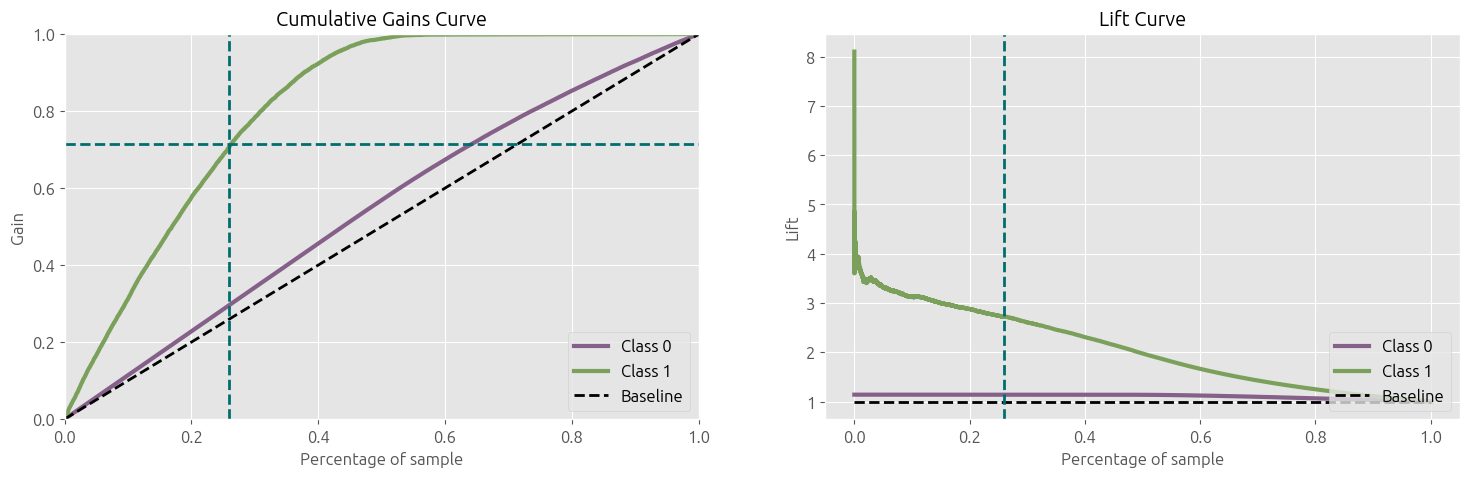

In [28]:
curve(y_val, yhat_lgb_tuned, axvline=0.26, axhline=0.714)

In [40]:
pickle.dump (lgb_model_tuned, open ('../src/models/lgbm.pkl', 'wb') )
pickle.dump (yhat_lgb_tuned, open ('../src/models/yhat_lgbm.pkl', 'wb') )

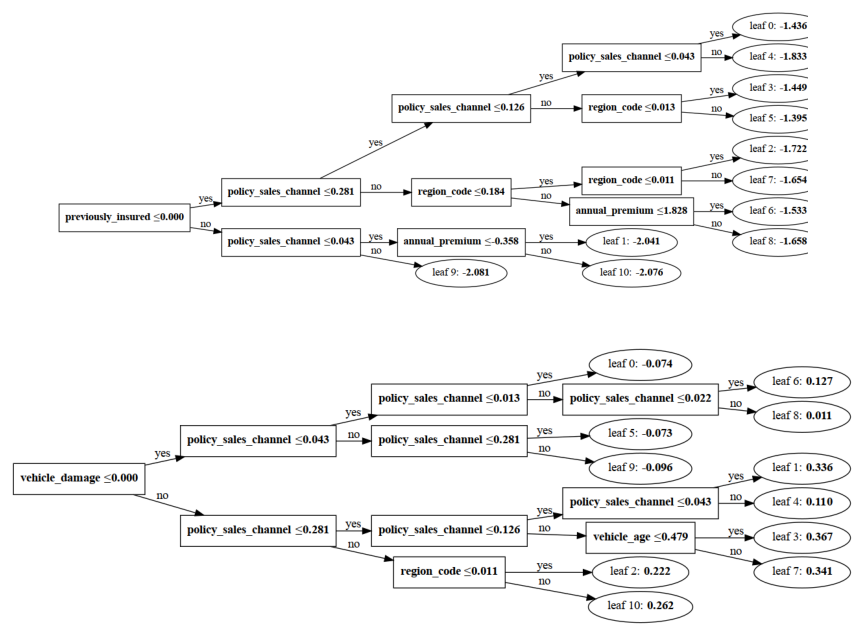

In [137]:
fig, ax = plt.subplots(nrows=2, figsize=(20,8), sharex=True);
lgb.plot_tree(lgb_model_tuned, tree_index=0,dpi=300, ax=ax[0]);
lgb.plot_tree(lgb_model_tuned, tree_index=1,dpi=300, ax=ax[1]);

## 8.3. Final Model

### 8.3.1 Optuna

#### 8.3.1.1 Model

In [6]:
lgb_model_tuned = pickle.load(open ('../src/models/lgbm.pkl', 'rb'))
yhat_lgb_tuned = pickle.load(open ('../src/models/yhat_lgbm.pkl', 'rb'))

In [7]:
test_raw = pd.read_csv('../data/processed/test.csv')
test = pd.read_csv('../data/interim/test_enconding.csv')
test_raw.head(2)

id Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  Response
0  138265   Male   42                1         36.0                   0    1-2 Year            Yes          2630.0                 156.0      258         0
1  273548   Male   45                1         15.0                   0    1-2 Year            Yes         30531.0                  26.0      274         1

In [8]:
test_encod = test.copy()
cols_selected = ['age', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel']

df_test = test_encod[cols_selected]
df_result_test=  test_raw.copy()

yhat_final_test = lgb_model_tuned.predict_proba(df_test)
df_result_test['score'] = yhat_final_test[:,1].tolist()


df_result_test = df_result_test.sort_values('score', ascending=False)
df_result_test = df_result_test.reset_index(drop=True)
df_result_test['ranking'] = df_result_test.index+1

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] feature_fraction is set=0.6778865985229834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6778865985229834
[LightGBM] [Warning] bagging_fraction is set=0.8599008768798327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8599008768798327


In [9]:
df_compared_test = test_raw.copy()
df_compared_test['response'] = test_raw['Response'].copy()
y_test = test_raw['Response'].copy()

#### 8.3.1.2 Scenarios

In [10]:
print (f"Dos {df_result_test.shape[0]} clientes, {round(df_result_test.loc[df_result_test['Response'] == 1].shape[0])} estão interessados no seguro automóvel - {round(df_result_test.loc[df_result_test['Response'] == 1].shape[0] / df_result_test.shape[0] *100 ,2) }% do total de clientes")

Dos 60978 clientes, 7523 estão interessados no seguro automóvel - 12.34% do total de clientes


In [11]:
df_result_test.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  Response     score  ranking
0  148643    Male   31                1         41.0                   0    1-2 Year            Yes         27072.0                 163.0      295         1  0.863546        1
1   39769    Male   32                1         11.0                   0    1-2 Year            Yes         30263.0                 163.0       61         1  0.857991        2
2  227476  Female   31                1         35.0                   0    < 1 Year            Yes         25609.0                 163.0       21         1  0.854932        3
3  371879  Female   31                1         41.0                   0    < 1 Year            Yes         28605.0                 124.0      148         1  0.854705        4
4  311863    Male   33                1         41.0                   0    < 1 Year            Yes         26052.0                 124.0       89         0  0.854705        5

In [12]:
a= df_result_test.loc[:100,:]
a[a['Response'] == 1].shape[0]

51

**COM 20.000 CHAMADAS TELEFÔNICAS:**  

*Com uma equipe de vendas fazendo 20.000 ligações, qual é a porcentagem de clientes interessados em adquirir um seguro automóvel?*


In [13]:
percent20 = round((20000 / df_result_test.shape[0]) * 100,2)
print(f'O percentual de clientes interessados em adquirir um seguro de automóvel é {percent20}%')

O percentual de clientes interessados em adquirir um seguro de automóvel é 32.8%


In [14]:
percent20 = 20000 / df_result_test.shape[0] 
ranking_metrics (df_compared_test, lgb_model_tuned, yhat_final_test, k=20000)

Precision_Top_K  Recall_Top_K      Model Name
0           0.3115        0.8281  LGBMClassifier

**COM 40.000 CHAMADAS TELEFÔNICAS** 

*E se a capacidade da equipe de vendas aumentar para 40.000 ligações, qual será o percentual de clientes interessados em adquirir um seguro de automóvel?*


In [15]:
percent40 = round((40000 / df_result_test.shape[0]) * 100,2)
print(f'O percentual de clientes interessados em adquirir um seguro de automóvel é {percent40}%')

O percentual de clientes interessados em adquirir um seguro de automóvel é 65.6%


In [16]:
percent40 = 40000 / df_result_test.shape[0] 
ranking_metrics (df_compared_test, lgb_model_tuned, yhat_final_test, k=40000 )

Precision_Top_K  Recall_Top_K      Model Name
0           0.1879        0.9993  LGBMClassifier

 **COM OS 80% DOS CLIENTES INTERESSADOS:** 

*Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?*

In [17]:
print(f'O time de vendas precisa fazer 19.000 ligações para contatar 80% dos clientes interessados em adquirir um seguro de automóvel')

O time de vendas precisa fazer 19.000 ligações para contatar 80% dos clientes interessados em adquirir um seguro de automóvel


In [19]:
percent80 = 19000 / df_result_test.shape[0] 
ranking_metrics (df_compared_test, lgb_model_tuned, yhat_final_test, k=19000 )

Precision_Top_K  Recall_Top_K      Model Name
0           0.3186        0.8047  LGBMClassifier